In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')

## Transform Observations into Line Segments for R Visualizations
The ggplot visualization, created in R, maps the storm track and also shows wind speed, acceleration, pressure, and rapid intensification events. For this, the data must be translated from individual observations to line segments with start and end at concurrent observations

In [17]:
def write_line_segments_to_csv(df):
    """
    creates a csv file containing the representative line segments of the HURDAT2 observations;
    the csv is used in an R Markdown file to create ggplot data visualizations;
    args: HURDAT observation dataframe; returns: none;
    """
    storm_codes = df.Storm_Identifier.unique() # get list of all storm identifiers
    
    # create text file for line segments and write columns headers
    f = open('Storm_Track_Segments.csv',"w") 
    f.write(f"Code,Name,Year,Month,Hour,Lat1,Lon1,Lat2,Lon2,Wind,Pressure,Accel,Bearing,Speed,Distance,Rapid_NHC24,kt34,kt50,kt64,\n")
    
    # iterate through storm list, creating a line segment connecting concurrent observations in the same storm
    for storm_index, storm in enumerate(storm_codes):
        df_storm = df[df.Storm_Identifier == storm ] # filter df by storm
        for i in range(len(df_storm)-1): # loop through n-1 starting points
            Code = df_storm.iloc[i,:].Storm_Identifier
            Name = df_storm.iloc[i,:].Storm_Name
            Year = df_storm.iloc[i,:].DateTime.year
            Month = df_storm.iloc[i,:].DateTime.month
            Hour = df_storm.iloc[i,:].DateTime.hour
            Lat1 = df_storm.iloc[i,:].Lat
            Lon1 = df_storm.iloc[i,:].Lon
            Lat2 = df_storm.iloc[i+1,:].Lat
            Lon2 = df_storm.iloc[i+1,:].Lon
            Wind = df_storm.iloc[i,:].Wind
            Pressure = df_storm.iloc[i,:].Pressure
            Accel = df_storm.iloc[i,:].Acceleration
            Bearing = df_storm.iloc[i,:].Bearing
            Speed = df_storm.iloc[i,:].Speed
            Distance = df_storm.iloc[i,:].Distance
            Rapid_NHC24 = df_storm.iloc[i,:].Rapid_NHC24
            kt34 = df_storm.iloc[i,:]['34kt_radius']
            kt50 = df_storm.iloc[i,:]['50kt_radius']
            kt64 = df_storm.iloc[i,:]['64kt_radius']
            f.write(f"{Code},{Name},{Year},{Month},{Hour},{Lat1},{Lon1},{Lat2},{Lon2},{Wind},{Pressure},{Accel},{Bearing},{Speed},{Distance},{Rapid_NHC24},{kt34},{kt50},{kt64},\n")
    f.close()

In [23]:
# Read in HURDAT2 observations from pickle
df = pd.read_pickle("12_15_2021.pkl")
# write_line_segments_to_csv(df)

## Create a Dataframe where Unit of Analysis is a Storm

Now we transition our unit of analysis from an observation of a storm to the storm itself. This new dataframe will have one row per storm from the HURDAT2 dataset. Changing the unit of analysis will allow us to understand macro characteristics of the data.

In [24]:
def create_df_all(df):
    """
    create a dataframe where storms are the unit of analysis;
    variable values are some summarization of values from observations in storm (min, max, whatever!);
    args: storm observation-level dataframe; returns: storm-level dataframe;
    """
    df_all = pd.DataFrame()
    codes = df.Storm_Identifier.unique() # get list of all storms
    for code in codes: # iterate through storm list
        df_strom = df[df.Storm_Identifier == code]
        df_all = df_all.append({ # calucluate interesting values to keep for storm-level data
            'Identifier'   : code,
            'Name'         : df_strom.iloc[0].Storm_Name,
            'Start_Date'   : df_strom.DateTime.min(),
            'End_Date'     : df_strom.DateTime.max(),
            'Min_Lat'      : df_strom.Lat.max(),
            'Max_Lat'      : df_strom.Lat.max(),
            'Min_Lon'      : df_strom.Lon.max(),
            'Max_Lon'      : df_strom.Lon.max(),
            'Max_Wind'     : df_strom.Wind.max(),
            'Min_Pressure' : df_strom.Pressure.max(),
            'Max_Accel'    : df_strom.Acceleration.max(),
            'Category'     : df_strom.Category.max(),
            'Max_34kt'     : df_strom['34kt_radius'].max(),
            'Max_50kt'     : df_strom['50kt_radius'].max(),
            'Max_64kt'     : df_strom['64kt_radius'].max(),
            'Rapid_NHC24'  : df_strom.Rapid_NHC24.any(),
        }, ignore_index=True)
        df_all.Category = df_all.Category.astype(int) # recast variable as integer
    return df_all

In [25]:
# Read in HURDAT2 observations from pickle
df = pd.read_pickle("12_15_2021.pkl")

# Create strom-level dataset
df_all = create_df_all(df)

Now we can learn about characteristics of the all the recorded storms since 1851!

In [26]:
df_all.Rapid_NHC24.sum() / len(df_all)

0.170997920997921

Since records began in 1850, we find that 17% of recorded storms would have been classified as Rapidly Intensifying according to the NHC definition.

## Create Python Visualization of Macro-Level Hurricane Trends

First, let's create a custom rounding function.

In [27]:
def custom_round(x, base=1):
    """ 
    custom rounding function that rounds down to the nearest base;
    args: 
        x (float): number to round
        base (float): base to round to
    returns:
        num (int): x rounded down the the nearest base
    """
    return int(base * math.floor(float(x)/base))

Then, we calculate the Year and Decade that each storm occurred in.

In [28]:
df_all['Year'] = pd.DatetimeIndex(df_all['Start_Date']).year
df_all['Decade'] = pd.DatetimeIndex(df_all['Start_Date']).year.astype(float)
df_all['Decade'] = df_all['Decade'].apply(lambda x: custom_round(x, base=10))

Now, just create the rest of the visualization! So easy!

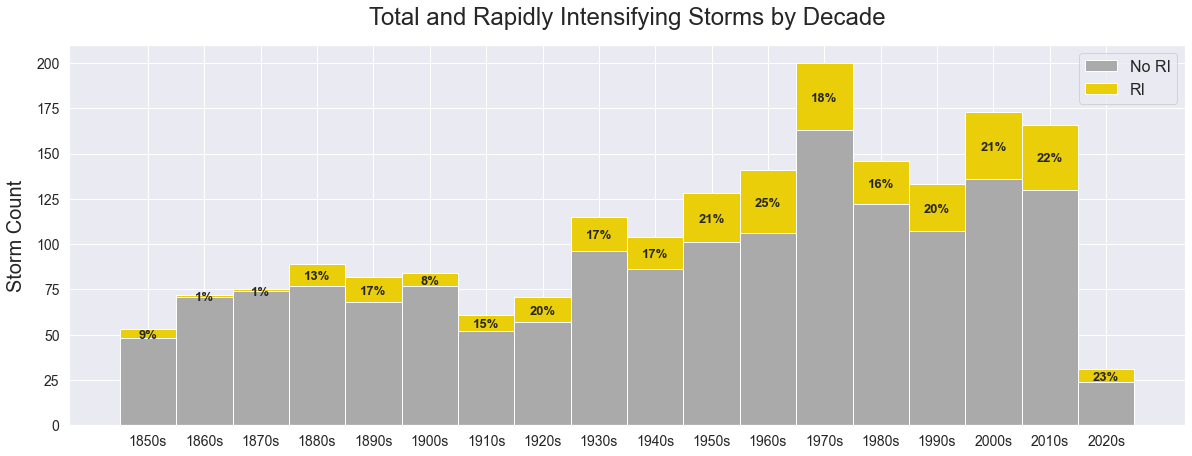

In [44]:
sns.set()
sns.set(rc = {'figure.figsize':(20,7)})

fig, ax = plt.subplots();

df2 = df_all.groupby(['Decade','Rapid_NHC24'])['Decade'].count().unstack('Rapid_NHC24').fillna(0)

colors = ['#aaaaaa', '#EACE09']
bottom = np.zeros(len(df2))

for i, col in enumerate(df2.columns):
  ax.bar(df2.index, df2[col], bottom=bottom, label=col, color=colors[i], width=10)
  bottom += np.array(df2[col])

# Sum up the rows of our data to get the total value of each bar.
totals = df2.sum(axis=1)
percs = df2[1.0]/(df2[1.0]+df2[0.0])

# Add labels to each bar.
for i, total in enumerate(totals):
  ax.text(totals.index[i], 
          df2.iloc[i][0.0] + .5*df2.iloc[i][1.0] - 2.7, 
          f"{int(100*round(percs.iloc[i],2))}%", 
          ha='center', weight='bold', fontsize=13)

plt.xticks(df2.index.to_numpy())
ax.set_xticklabels([ f"{d}s" for d in df2.index.to_numpy()])

plt.ylabel('Storm Count',fontsize=20,labelpad=10)

ax.tick_params(axis='both', labelsize=14 )

ax.set_title('Total and Rapidly Intensifying Storms by Decade', fontsize=24, pad=20)
ax.legend(labels=('No RI','RI'), prop={'size': 16});


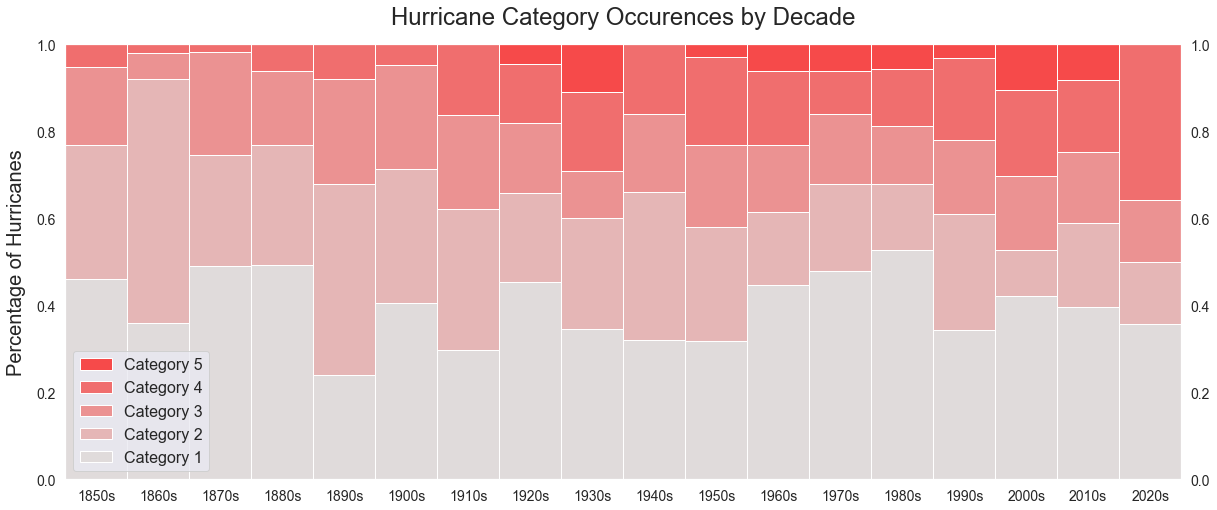

In [43]:
from matplotlib.colors import LinearSegmentedColormap

sns.set()
sns.set(rc = {'figure.figsize':(20,8)})

fig, ax = plt.subplots()

df2 = df_all.groupby(['Decade','Category'])['Decade'].count().unstack('Category').fillna(0)
df2 = df2.drop([2020],axis=0)

df2 = df_all.groupby(['Decade','Category'])['Decade'].count().unstack('Category').fillna(0)
df2 = df2.drop([0], axis=1)
df2 = df2.div(df2.sum(axis=1), axis=0)
colors = ['#F64A4A','#F06E6E','#EB9292','#E5B6B6','#E0DBDB']
bottom = np.zeros(len(df2))

for i, col in enumerate(df2.columns):
  ax.bar(df2.index, df2[col], bottom=bottom, label=col, color=colors[4-i], width=10)
  bottom += np.array(df2[col])

plt.xticks(np.arange(1850, 2030, step=10))
ax.set_xticklabels([ f"{d}s" for d in df2.index.to_numpy()])

ax.tick_params(axis='both', labelsize=14, labelright=True )
ax.set_xlim([1845, 2025])
ax.set_ylim([0, 1])

ax.set_ylabel('Percentage of Hurricanes',fontsize=20,labelpad=10)

ax.set_title('Hurricane Category Occurences by Decade', fontsize=24, pad=20)
labels = ('Category 1','Category 2','Category 3','Category 4','Category 5')

handles, labelss = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left', prop={'size': 16})